In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '210728_compare_mouse_models_without_individual_length_features'

In [8]:
save_images = True


In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
def get_prediction_score(in_folder):

    agg = []

    for condition in all_de['condition'].unique():

        p = export.get_material_path(
            '{}/predictions_{}.csv'.format(in_folder, condition))
        if os.path.exists(p):
            agg.append(pd.read_csv(p))


    df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
    df['mean'] = df.mean(1)
    d = pd.merge(sign.reset_index(), df[['mean']].reset_index())
    f = d['significant'] > 0
    d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

    zeros = sum(~f)

    h = []
    for j in range(zeros):
        h.append(-1 + random.randrange(0, 10)/20)
    d.loc[~f, 'log_significant'] = h

    f = d['condition'].str.contains('_0_4_[0-9]*$')
    d = d[f]

    d = pd.merge(d, all_de[['condition', 'younger', 'older']].drop_duplicates())

    d = d.set_index('condition')

    helper = pd.merge(
        d.reset_index()[['condition', 'mean']],
        all_de[['condition', 'tissue', 'older']].drop_duplicates()
    ).pivot(index='tissue', columns='older', values='mean')
    
    return helper

In [15]:
helper_g = get_prediction_score('210728_predict_fold_change_mouse_24_no_gene_SumACGT')
helper_g = helper_g.rename(columns={24: 'no_gene_length'})

In [16]:
helper_c = get_prediction_score('210728_predict_fold_change_mouse_24_no_rna_cds_SumACGT')
helper_c = helper_c.rename(columns={24: 'no_cds_length'})

In [17]:
helper_r = get_prediction_score('210728_predict_fold_change_mouse_24_no_rna_full_SumACGT')
helper_r = helper_r.rename(columns={24: 'no_rna_length'})

In [18]:
helper_a = get_prediction_score('190406_predict_fold_change_mouse')
helper_a = helper_a[[24]].rename(columns={24: 'all'})

In [19]:
m = pd.concat([helper_g, helper_r, helper_c, helper_a], axis=1)

In [20]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr', 
        annot=True,
        vmin=0,
        vmax=0.5
    )

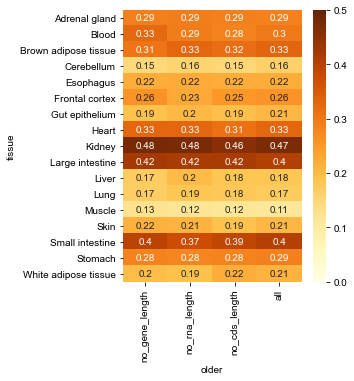

In [21]:
nice_plot(m)



if save_images:
    export.export_image(
    '{}/table.pdf'.format(out_folder))